## Goal
Whether the survey respondent received the **seasonal flu vaccine**
- Predictive question - who is likely (and unlikely) to recieve the seasonal flu vaccine?
Data: National 2009 H1N1 Flu Survey (telephone surveys) 

### Random rachel thoughts
 - telephone surveys may no longer be the best way to collect this data? Too many spam callers
 - whenever we talk about vaccine compliance, it is also important to mention the anti-vaxx movement which is a portion of the population who have stated they will not get vaccines- something we won't address here
 - I chose to look at the seasonal flu instead of the H1N1 flu, because with the current covid vaccine I feel that we have moved into a stage of more routine vaccinations (like the seasonal flu) vrs. vaccinations due to a specific, but eventually fading concern (H1N1). H1N1 came onto the scene in 2009, when this survey was taken, so it is a good indicator of who does and doesn't vaccinate when there is a 'break out'. 

## Looking at the Data

### Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import statistics

from scipy import stats
from scipy.stats import chi2_contingency
from seaborn import load_dataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix




### Reading in the CSV files

"Submission Format: This file serves as an example for how to format your submission. It contains the index and columns for our submission prediction. The two target variable columns are filled with 0.5 and 0.7 as an example. Your submission to the leaderboard must be in this exact format (with different prediction values) in order to be scored successfully!"

In [2]:
submission_format = pd.read_csv("Data/submission_format.csv")
submission_format.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.5,0.7
1,26708,0.5,0.7
2,26709,0.5,0.7
3,26710,0.5,0.7
4,26711,0.5,0.7


"Test Features: These are the features for observations that you will use to generate the submission predictions after training a model. We don't give you the labels for these samples—it's up to you to generate them."

In [3]:
test_features = pd.read_csv("Data/test_set_features.csv")
test_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


"Training Features: These are the input variables that your model will use to predict the probability that people received H1N1 flu and seasonal flu vaccines. There are 35 feature columns in total, each a response to a survey question. These questions cover several different topics, such as whether people observed safe behavioral practices, their opinions about the diseases and the vaccines, and their demographics. Check out the [problem description page](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/)
for more information."

In [4]:
features = pd.read_csv("Data/training_set_features.csv")
features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Descriptions of the features (taken from [here](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/)): 

For all binary variables: 0 = No; 1 = Yes.

- h1n1_concern - Level of concern about the H1N1 flu. 0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
- h1n1_knowledge - Level of knowledge about H1N1 flu. 0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
- behavioral_antiviral_meds - Has taken antiviral medications. (binary)
- behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
- behavioral_face_mask - Has bought a face mask. (binary)
- behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
- behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
- behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
- behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
- doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
- doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
- chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
- child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
- health_worker - Is a healthcare worker. (binary)
- health_insurance - Has health insurance. (binary)
- opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness. 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- age_group - Age group of respondent.
- education - Self-reported education level.
- race - Race of respondent.
- sex - Sex of respondent.
- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
- marital_status - Marital status of respondent.
- rent_or_own - Housing situation of respondent.
- employment_status - Employment status of respondent.
- hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
- census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
- household_adults - Number of other adults in household, top-coded to 3.
- household_children - Number of children in household, top-coded to 3.
- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.


"Training Labels: These are the labels corresponding to the observations in the training features. There are two target variables: h1n1_vaccine and seasonal_vaccine. Both are binary variables, with 1 indicating that a person received the respective flu vaccine and 0 indicating that a person did not receive the respective flu vaccine. Note that this is what is known as a "multilabel" modeling task."

In [6]:
labels = pd.read_csv("Data/training_set_labels.csv")
print("labels.shape", labels.shape)
labels.head()

labels.shape (26707, 3)


,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [7]:
#checking if the features and lable dataframes match up 
np.testing.assert_array_equal(features.index.values, labels.index.values)

As we see above, most of our columns have some sort of missing values. Additionally, there are many numeric columns. Before we start to deal with either of these, lets examin the feature descriptions and decide if we want to use those features at all. 

### Feature Selection 

Lets remove all of the columns related to only the H1N1 vaccine:
`h1n1_concern`, `h1n1_knowledge`, `doctor_recc_h1n1`, `opinion_h1n1_vacc_effective`, `opinion_h1n1_risk`, `opinion_h1n1_sick_from_vacc`

Additionally, there are some columns where the information has been scrambled (presumably to protect the respondants personal information) so lets remove those as well as we can't extract any usefull information without knowing what they are coded for: 
`hhs_geo_region`, `employment_industry`, `employment_occupation`

In [8]:
def features_drop(df):
    df.drop(['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'hhs_geo_region', 'employment_industry', 'employment_occupation'], axis = 1, inplace = True)

features_drop(features)


### Missing Values

In [9]:
features.isnull().sum()

respondent_id                      0
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
census_msa                         0
household_adults                 249
household_children               249
d

For all of the binary data, lets just replace the NaN's with zeros - it's a guess but its a pretty decent one, particularly in the case of healthcare, as the Affordable Care Act (which mandated healthcare) was only enacted in 2010, after this data was collected. 

In [10]:
cross_tab = pd.crosstab(features['health_insurance'], labels['seasonal_vaccine'], margins = True)
print(cross_tab)
chi2, p, dof, expected = chi2_contingency(cross_tab)
print(chi2, p)

seasonal_vaccine     0     1    All
health_insurance                   
0.0               1338   398   1736
1.0               5866  6831  12697
All               7204  7229  14433
582.2867466798792 1.0559310374176207e-124


In [11]:
binary_data = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask' ,'behavioral_wash_hands', 
 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 
 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance']

for column in binary_data:
    features[column].replace(np.nan, 0, inplace = True)
    

In [12]:
features.isnull().sum()

respondent_id                     0
behavioral_antiviral_meds         0
behavioral_avoidance              0
behavioral_face_mask              0
behavioral_wash_hands             0
behavioral_large_gatherings       0
behavioral_outside_home           0
behavioral_touch_face             0
doctor_recc_seasonal              0
chronic_med_condition             0
child_under_6_months              0
health_worker                     0
health_insurance                  0
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status              1463
census_msa                        0
household_adults                249
household_children              249
dtype: int64

For the opinion questions `opinion_seas_vacc_effective`, `opinion_seas_risk`, `opinion_seas_sick_from_vacc`  (which are ordinal) lets take the median of each column and use that to replace the NaN's. 

In [13]:
opinions = ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

for column in opinions:
    features[column].replace(np.nan, features[column].median(), inplace = True)

Now lets look at the categorical columns that we have left over - we'll probably be best off OneHotEncoding these later. Let's relable all of these missing values as 'missing', so we can keep the rest of the data. 

In [14]:
miss_cat_features = ['education', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status']

In [15]:
for column in miss_cat_features:
    features[column].replace(np.nan, statistics.mode(features[column]), inplace = True)

In [16]:
features['income_poverty'].value_counts()

<= $75,000, Above Poverty    17200
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

Finally, lets replace the missing values of `household_adults` and `household_children` with the median too. 

In [17]:
for column in ['household_adults', 'household_children']:
    features[column].replace(np.nan, features[column].median(), inplace = True)

In [18]:
features.isnull().sum()

respondent_id                  0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
census_msa                     0
household_adults               0
household_children             0
dtype: int64

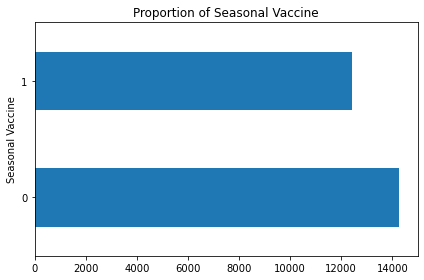

In [19]:
fig, ax = plt.subplots()
labels['seasonal_vaccine'].value_counts().plot.barh(title="Proportion of Seasonal Vaccine")

ax.set_ylabel("Seasonal Vaccine")

fig.tight_layout()

Lets drop the information we don't need from the labels dataframe


In [20]:
labels.drop(['h1n1_vaccine', 'respondent_id'], axis = 1, inplace= True)
labels.isnull().sum()
labels.head()

,seasonal_vaccine
0,0
1,1
2,0
3,1
4,0


In [21]:
labels.head()

,seasonal_vaccine
0,0
1,1
2,0
3,1
4,0


Lets split our data into training and testing sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)
X_train

,respondent_id,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,...,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children
25194,25194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12 Years,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,Non-MSA,1.0,1.0
14006,14006,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",2.0,1.0
11285,11285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,College Graduate,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Principle City",0.0,1.0
2900,2900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,College Graduate,White,Male,Below Poverty,Not Married,Own,Employed,"MSA, Not Principle City",0.0,0.0
19083,19083,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,21575,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,Some College,White,Male,"> $75,000",Not Married,Own,Not in Labor Force,"MSA, Principle City",0.0,0.0
5390,5390,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,Some College,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,"MSA, Principle City",0.0,0.0
860,860,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,Non-MSA,1.0,0.0
15795,15795,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,College Graduate,Black,Female,"> $75,000",Married,Own,Employed,"MSA, Principle City",1.0,0.0


In [23]:
#checking if the features and lable dataframes match up 
np.testing.assert_array_equal(X_test.index.values, y_test.index.values)

Now lets standardize our numeric data, so that it's all on the same scale for X_train and X_test

I'm not going to standardize the bianary data (see reasoning [here](https://stats.stackexchange.com/questions/59392/should-you-ever-standardise-binary-variables)), but as so much of my numeric data is binary (and more will be after we OneHotEncode the categorical data) we will use MinMaxScaler to keep the remaining numeric data on a 0-1 scale. 

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 25194 to 23654
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                20030 non-null  int64  
 1   behavioral_antiviral_meds    20030 non-null  float64
 2   behavioral_avoidance         20030 non-null  float64
 3   behavioral_face_mask         20030 non-null  float64
 4   behavioral_wash_hands        20030 non-null  float64
 5   behavioral_large_gatherings  20030 non-null  float64
 6   behavioral_outside_home      20030 non-null  float64
 7   behavioral_touch_face        20030 non-null  float64
 8   doctor_recc_seasonal         20030 non-null  float64
 9   chronic_med_condition        20030 non-null  float64
 10  child_under_6_months         20030 non-null  float64
 11  health_worker                20030 non-null  float64
 12  health_insurance             20030 non-null  float64
 13  opinion_seas

All of the non-binary data we have seems to be ordinal or interval (not continuous). As such, the data is not distributed along a normal (Gaussian) curve, so we should use MinMaxScaler() instead of Standard scaler. 

In [25]:
num_ordinal = ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc',
              'household_adults', 'household_children']
X_train[num_ordinal]

,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
25194,4.0,2.0,2.0,1.0,1.0
14006,4.0,5.0,4.0,2.0,1.0
11285,4.0,2.0,1.0,0.0,1.0
2900,4.0,4.0,2.0,0.0,0.0
19083,1.0,2.0,4.0,1.0,0.0
...,...,...,...,...,...
21575,4.0,2.0,1.0,0.0,0.0
5390,4.0,2.0,4.0,0.0,0.0
860,4.0,2.0,2.0,1.0,0.0
15795,1.0,1.0,4.0,1.0,0.0


We see that the above data is not normally distributed, so lets scale the numeric data using MinMaxScaler()

In [26]:
y_train.head()

,seasonal_vaccine
25194,0
14006,1
11285,1
2900,0
19083,1


In [27]:
scaler = MinMaxScaler()
#scaling numeric training data 
X_train_minmax = pd.DataFrame(scaler.fit_transform(X_train[num_ordinal]), index = X_train.index, columns = X_train[num_ordinal].columns)
X_train.drop(num_ordinal, axis=1, inplace = True)
X_train_scaled = pd.DataFrame.join(X_train, X_train_minmax)

#scaling numberic testing data
X_test_minmax = pd.DataFrame(scaler.transform(X_test[num_ordinal]), index = X_test.index, columns = X_test[num_ordinal].columns)
X_test.drop(num_ordinal, axis=1, inplace = True)
X_test_scaled = pd.DataFrame.join(X_test, X_test_minmax)

In [28]:
np.testing.assert_array_equal(X_test_scaled.index.values, y_test.index.values)

Then lets use `pd.dummies` to get dummies for our string categorical X_train and X_test data

In [29]:
st_cat_features = ['age_group','education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']


In [30]:
#Dummies for X_train
X_train_dummies = pd.get_dummies(X_train_scaled[st_cat_features], prefix=st_cat_features, drop_first=True)
X_train_preproc = X_train_scaled.drop(st_cat_features, axis=1)
X_train_preproc = pd.concat([X_train_preproc, X_train_dummies], axis = 1)

In [31]:
#Dummies for X_test
X_test_dummies = pd.get_dummies(X_test_scaled[st_cat_features], prefix=st_cat_features, drop_first=True)
X_test_preproc = X_test_scaled.drop(st_cat_features, axis=1)
X_test_preproc = pd.concat([X_test_preproc, X_test_dummies], axis = 1)

In [32]:
y_train.head()

,seasonal_vaccine
25194,0
14006,1
11285,1
2900,0
19083,1


In [33]:
#checking if the dataframes match up 

np.testing.assert_array_equal(X_train_preproc.index.values, y_train.index.values)

In [34]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 25194 to 23654
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   seasonal_vaccine  20030 non-null  int64
dtypes: int64(1)
memory usage: 313.0 KB


In [35]:
#lets look at what happens when we look at our data through a regression model


#fit model 
base_log_reg = LogisticRegression(solver = 'liblinear')

y_train_ravel = np.ravel(y_train, order = 'C')

base_log_reg.fit(X_train_preproc, y_train_ravel)

base_log_reg.score(X_train_preproc, y_train_ravel)

0.7669495756365452

In [36]:
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C': [0.001,0.01,0.1,1,10,100,1000]   
}

gs_log_reg = GridSearchCV(base_log_reg, param_grid)
gs_log_reg.fit(X_train_preproc, y_train_ravel)

GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [37]:
gs_log_reg.best_params_

{'C': 1, 'penalty': 'l1'}

In [38]:
optimized_log_reg = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')